# <a id="TOC"> Start </a>



In [1]:
import backtesting # To backtest the strategy
import heuristic_pf_construct # To test out the weighted strategies.
import eda_pipeline

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [1]:
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]

columns_wanted = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

data = yf.download(
    tickers=tickers,
    period="3y",          # or use start="2022-01-01", end="2025-11-26"
    interval="1d",
    group_by="ticker",    # organizes returned DataFrame by ticker first
    threads=True,
    auto_adjust=False     # keep Adj Close column rather than auto-adjusting all columns
)

# --- 4) Example: extract only needed columns into a MultiIndex DataFrame ---
# data[ticker][col] access pattern; create a cleaned df with tickers on top-level columns
clean = data.copy()
clean.columns = [f"{column}" for column in data.columns]
# now clean is a DataFrame with columns like ('JPM','Open'), ('JPM','Close'), ...

# --- 5) Quick derived metrics examples ---
# 5  using Adj Close
adj = pd.concat({t: data[t]["Adj Close"] for t in tickers}, axis=1)



# 5b) for daily returns
daily_returns = adj.pct_change().dropna()




NameError: name 'yf' is not defined

In [4]:
# Data preprocessing step.

# Currently first want a high level summary of the data


# 1. Handling Missing Data
# Creating a helper function to check for missing data that can be reused in the future as well
def missing_and_duplicates(df: pd.DataFrame, show_top: int = 20) -> Dict[str, pd.DataFrame]:
    """
    Return dataframes listing missing values and duplicate row counts.
    Justification: Missingness and duplication are common sources of bias/errors.
    """
    total = len(df)
    missing = df.isna().sum().sort_values(ascending=False)
    missing_percent = (missing / total * 100).round(4)
    missing_df = pd.concat([missing, missing_percent], axis=1, keys=["missing_count", "missing_percentage"])
    missing_df = missing_df[missing_df['missing_count'] > 0]
    
    duplicate_count = df.duplicated().sum()
    print(f"Total rows: {total}, Duplicated rows: {duplicate_count}")

    if duplicate_count > 0:
        print("First 5 duplicated rows (by index peek):")
        print(df[df.duplicated(keep=False)].head())
    
    print("\nTop missing columns:")
    print(missing_df.head(show_top))
    
    return {"missing": missing_df, "duplicates": duplicate_count}

data_quality_summary_dict = missing_and_duplicates(adj)

data_quality_summary_dict["duplicates"]


Total rows: 776, Duplicated rows: 0

Top missing columns:
        missing_count  missing_percentage
JPM                23              2.9639
GS                 23              2.9639
MS                 23              2.9639
BAC                23              2.9639
C                  23              2.9639
UBS                23              2.9639
BARC.L             18              2.3196
HSBA.L             17              2.1907
BNP.PA              8              1.0309


np.int64(0)

In [5]:
adj[adj.isna().any(axis=1)]

,JPM,GS,MS,BAC,C,UBS,BARC.L,HSBA.L,BNP.PA
Date,,,,,,,,,
2022-12-27,122.353065,318.724915,76.857468,30.224688,39.802979,17.140705,NaN,NaN,42.974621
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714733
2023-01-16,NaN,NaN,NaN,NaN,NaN,NaN,182.285568,594.791504,47.399414
2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,175.673340,619.337585,52.126614
2023-04-10,120.593803,305.039764,76.511879,26.128340,42.124279,19.035009,NaN,NaN,NaN
2023-05-01,133.144470,319.692841,80.785194,27.157013,43.254353,18.911892,NaN,NaN,NaN
2023-05-08,129.250107,306.494781,77.569595,25.894550,42.439617,18.553280,NaN,NaN,46.388710
2023-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.757893
2023-06-19,NaN,NaN,NaN,NaN,NaN,NaN,153.324051,613.909058,48.362320


Based on the analysis above - we can identify that the missing values are caused by markets closing due to holidays on those days. The preceding analysis opts for a forward fill to deal with thees values.

The next analysis requires us to check that there are no stupid values like 0 or negative values. 

In [6]:
adj[(adj <= 0).any(axis=1)]

,JPM,GS,MS,BAC,C,UBS,BARC.L,HSBA.L,BNP.PA
Date,,,,,,,,,


# <a id="BNP TSA"> __BNP TSA__ </a>
In this next section - we want to perform some analysis on the time-series behaviour of BNP.


<Figure size 1000x300 with 0 Axes>

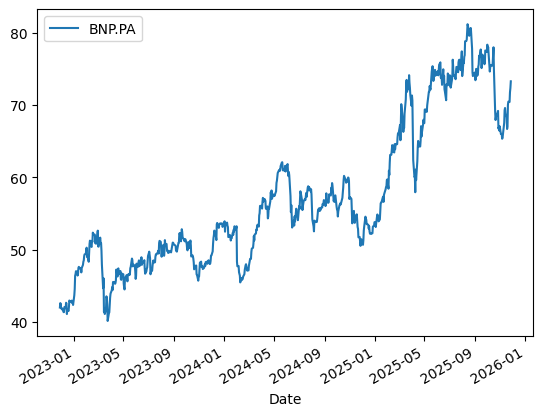

In [7]:
import eda_pipeline

target = "BNP.PA"

df = eda_pipeline.eda_pipeline(adj)


# Want to do some TSA on the returns of target
target_series = df[[target]]

plt.figure(figsize=(10,3))
target_series.plot()
plt.show()


A clear trend is observed - we can try differencing the data and obtaining a stationary time series.

<Axes: xlabel='Date'>

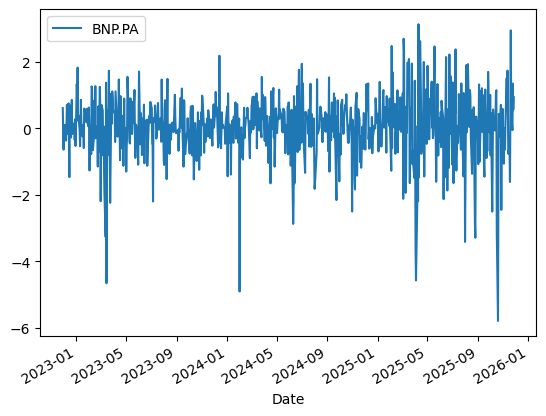

In [8]:
# Want to try differencing the df

target_returns= target_series.diff()
target_returns.dropna(inplace=True)

target_returns.plot()



,BNP.PA
count,775.000000
mean,0.040336
std,0.954522
min,-5.790001
25%,-0.382643
50%,0.095501
75%,0.570000
max,3.134792


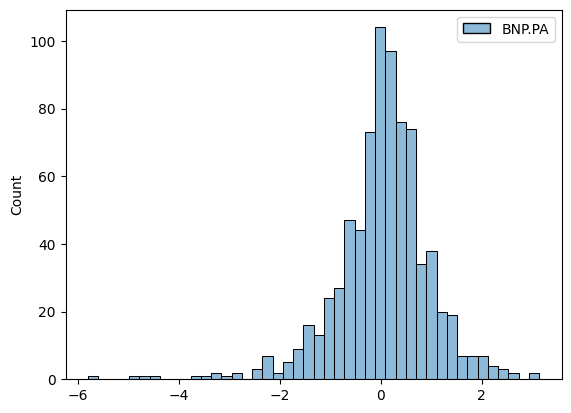

In [9]:
# plot the returns as a histogram

sns.histplot(target_returns)

target_returns.describe()

In [10]:
target_series["log_returns"] = np.log(target_series.loc[:, "BNP.PA"]).diff()

C:\Users\trund\AppData\Local\Temp\ipykernel_26672\321427538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_series["log_returns"] = np.log(target_series.loc[:, "BNP.PA"]).diff()


<Axes: xlabel='log_returns', ylabel='Count'>

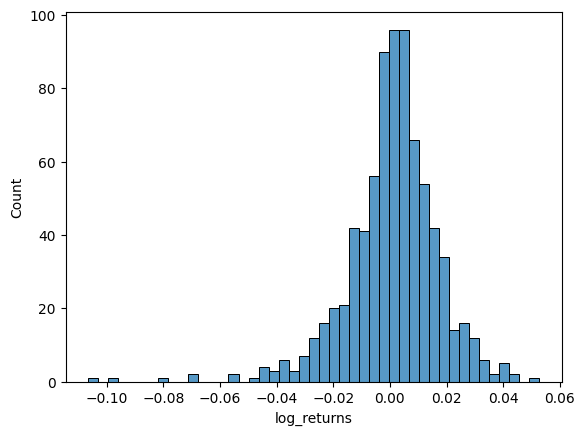

In [11]:
sns.histplot(target_series["log_returns"])

The returns still look skewed despite the log transformation. For the purposes of predicting returns easier it might be helpful to just keep the time-series in the regular differences.  

In [ ]:
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import acf, adfuller, kpss, q_stat
from statsmodels.stats.diagnostic import acorr_ljungbox # Corrected import for Ljung-Box test

result = acorr_ljungbox(series.dropna(), lags=lags, return_df=False)
    
    # We are interested in the test that includes all specified lags, which is the last element [-1]
    lb_stat = result[0][-1]
    p_value = result[1][-1]

c:\Users\trund\QRT\venv\lib\site-packages\statsmodels\tsa\stattools.py:570: RuntimeWarning: divide by zero encountered in divide
  * np.cumsum((1.0 / (nobs - np.arange(1, len(x) + 1))) * x ** 2)


np.float64(0.025248738426295936)


--- Diagnostics for Original Series ---
Mean: 57.0434
Std Dev: 10.1717
First 5 ACF Values (Lag 1 to 5):
  Lag 1: 0.9926
  Lag 2: 0.9851
  Lag 3: 0.9774
  Lag 4: 0.9700
  Lag 5: 0.9626
---------------------------------


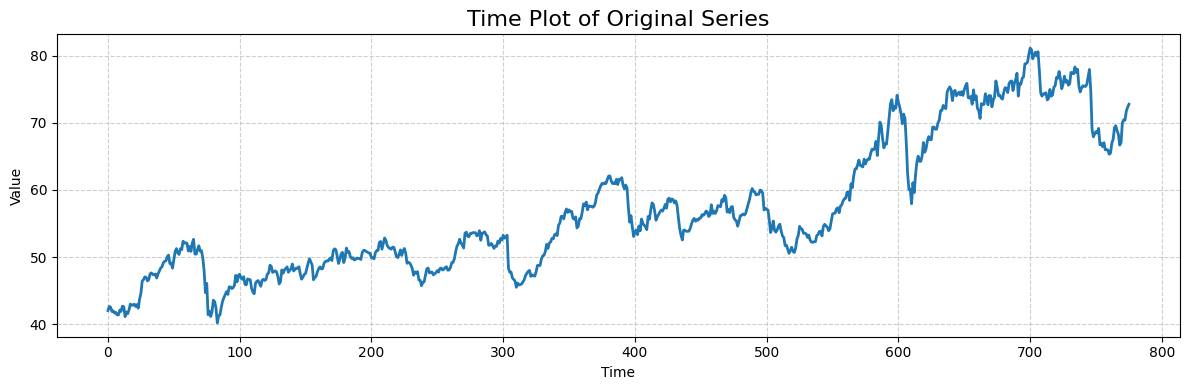

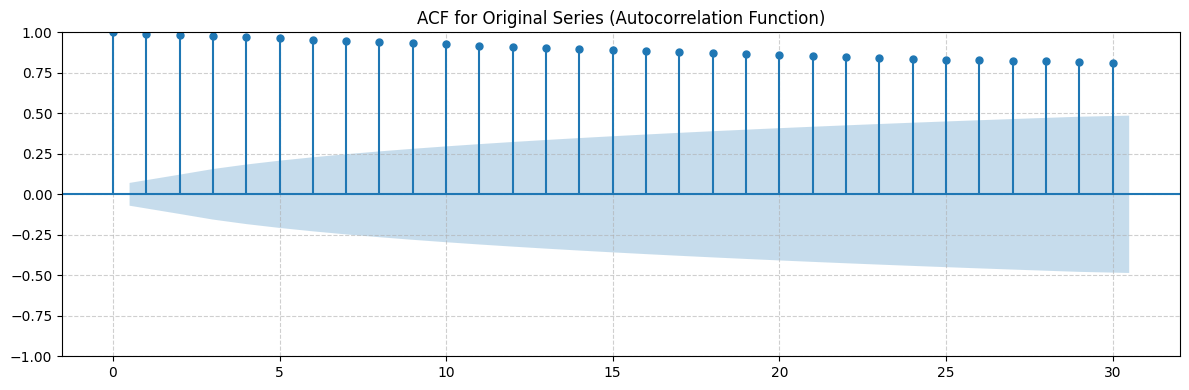

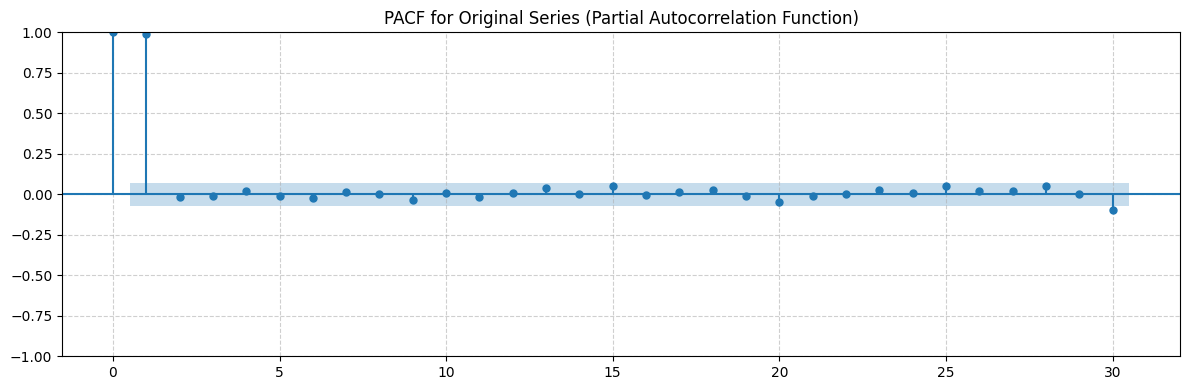

In [ ]:
plot_autocorrelations(pd.Series(target_series.to_numpy().flatten()), lags=30)

Based on the analysis above - we can deduce that there are no stupid values. We are now ready to start programming the strategy.

# <a id="Create Strategy">__Strategy Creation__ </a>

In [ ]:
import backtesting # To backtest the strategy
import heuristic_pf_construct # To test out the weighted strategies.
import eda_pipeline

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Recreation of the dataset we are trying to retrieve.
tickers = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
    "UBS",   # UBS (NYSE / SIX)
    "BARC.L",# Barclays (LSE)
    "HSBA.L",# HSBC (LSE)
    "BNP.PA" # BNP Paribas (Euronext Paris)
]

columns_wanted = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

data = yf.download(
    tickers=tickers,
    period="3y",          # or use start="2022-01-01", end="2025-11-26"
    interval="1d",
    group_by="ticker",    # organizes returned DataFrame by ticker first
    threads=True,
    auto_adjust=False     # keep Adj Close column rather than auto-adjusting all columns
)

# --- 5) Quick derived metrics examples ---
# 5  using Adj Close
adj = pd.concat({t: data[t]["Adj Close"] for t in tickers}, axis=1)

adj = eda_pipeline.eda_pipeline(adj)
"""
Currently my implementation is spaghetti code - but we will need to fix this later.
"""

def equal_weighting(
    tradable_assets, 
    history, 
    nav_history, 
    #price_col: str = "price",
    #risk_col: str = "risk",
    #mcap_col: str = "mcap",            # unused but kept for identical signature
    #long_only: bool = True,
    gross_exposure: float = 1.0,
) -> pd.DataFrame:
    # With no amount in cash. 
    """
    Equal weighting. If long_only=True returns all weights = 1/N.
    If long_only=False returns centered long-short equal-magnitude weights (gross exposure scaled).
    """
    n = len(tradable_assets)
    if len(history) == 0:
        return 0, pd.Series(data=np.zeros(len(tradable_assets)), index=tradable_assets)
    #if long_only:
    weights = np.ones(n) / (n + 1)
    cash = 1 / n + 1
    #else:
        # initial pattern: +1 for first half, -1 for second half (user may want to pre-sort df by signal)
        #pattern = np.concatenate([np.ones(n // 2), -np.ones(n - n // 2)])
        #weights = _normalize_weights(pattern, long_only=False, gross_exposure=gross_exposure)

    labels_and_weights = pd.Series(data=weights, index=tradable_assets)
    return cash, labels_and_weights

In [13]:
# The first strategy we will start implementing is the equal weights strategy - this will be based on the weights of the previous trading day. 

EqualWeightStrategy = backtesting.FunctionStrategy(name="equal_weight", 
                                                   user_fn=heuristic_pf_construct.equal_weighting)

tradable_assets = [
    "JPM",   # JPMorgan (NYSE)
    "GS",    # Goldman Sachs (NYSE)
    "MS",    # Morgan Stanley (NYSE)
    "BAC",   # Bank of America (NYSE)
    "C",     # Citigroup (NYSE)
]

# Need to wrap the strategy function into a strategy to be compatible with the pipeline
strategy_name = "equal_weights"
equal_weights = equal_weighting


backtester = backtesting.Backtester(tradable_assets=tradable_assets,
                                    data = adj,
                                    strategy_fn=equal_weights,
                                    strategy_name=strategy_name,
                                    allow_short=False,
                                    cash_start=100000,
                                    riskfree_per_period=0.04 / 252)

backtester.run(verbose=False)

In [7]:
backtester.calculate_results()
pnl_array = backtester.pnl_comparison_array(target_risk=0.4)



In [8]:
# --- parameters ---
initial_investment = 100_000
SNP = "SPY"   # S&P 500 ETF

# --- download daily data ---
data = yf.download(
    tickers=SNP,
    period="3y",          # or use start="2022-01-01", end="2025-11-26"
    interval="1d",
    group_by="ticker",    # organizes returned DataFrame by ticker first
    threads=True,
    auto_adjust=False     # keep Adj Close column rather than auto-adjusting all columns
)

# --- use Adjusted Close for correct return calculation (dividends!) ---
prices = data[SNP]["Adj Close"]

# --- compute returns ---
returns = prices.pct_change().dropna()

# --- compute portfolio value series ---
# assume you buy-and-hold SPY with the full initial amount
shares = initial_investment / prices.iloc[0]
portfolio_value = shares * prices

# --- put everything into a single DataFrame ---
benchmark = pd.DataFrame({
    "spy_daily_return": returns,
})

print(benchmark.tail())


[*********************100%***********************]  1 of 1 completed

            spy_daily_return
Date                        
2025-11-20         -0.015242
2025-11-21          0.009961
2025-11-24          0.014719
2025-11-25          0.009406
2025-11-26          0.006903


In [9]:
backtester.calculate_alpha(benchmark=benchmark)

NB: The alpha value is given in the constant term. 



AttributeError: 'OLS' object has no attribute 'results'